In [1]:
import makemore
import matplotlib.pyplot as plt
import torch

In [2]:
CHARS = makemore.CHARS

In [ ]:
words = makemore.load_words_from_file('names.txt')
counts = makemore.bigram_model(words)
counts

In [ ]:
plot_bigram_frequencies(counts)

In [3]:
words = makemore.load_words_from_file('american-english.txt')
counts = makemore.bigram_model(words)
counts

tensor([[    0,  4278,  4418,  6951,  4446,  2927,  3076,  2491,  2748,  2837,
           861,   768,  2416,  4175,  1437,  1740,  5623,   351,  4129,  8448,
          3696,  1680,  1121,  2003,    33,   286,   191],
        [ 1751,    40,  1764,  2624,  1856,   215,   431,  1404,   260,  1552,
            49,   617,  5127,  1889,  6625,    57,  1518,    53,  5514,  2963,
          7098,   924,   748,   483,   164,   806,   266],
        [  174,  1669,   432,    30,    40,  1756,    12,     4,    19,  1234,
            47,     2,  1962,    34,    29,  1352,    10,     0,  1078,   396,
            78,   999,    17,    13,     0,   148,     0],
        [  799,  3404,     3,   397,    10,  2471,     2,     5,  3043,  1659,
             0,  1911,   967,     9,    10,  4074,     1,    44,  1423,   290,
          1691,  1123,     2,     0,     0,   283,    12],
        [ 8051,  1109,   105,    62,   448,  4480,    60,   300,    80,  3332,
            66,     8,   571,   118,   105,  1151,   

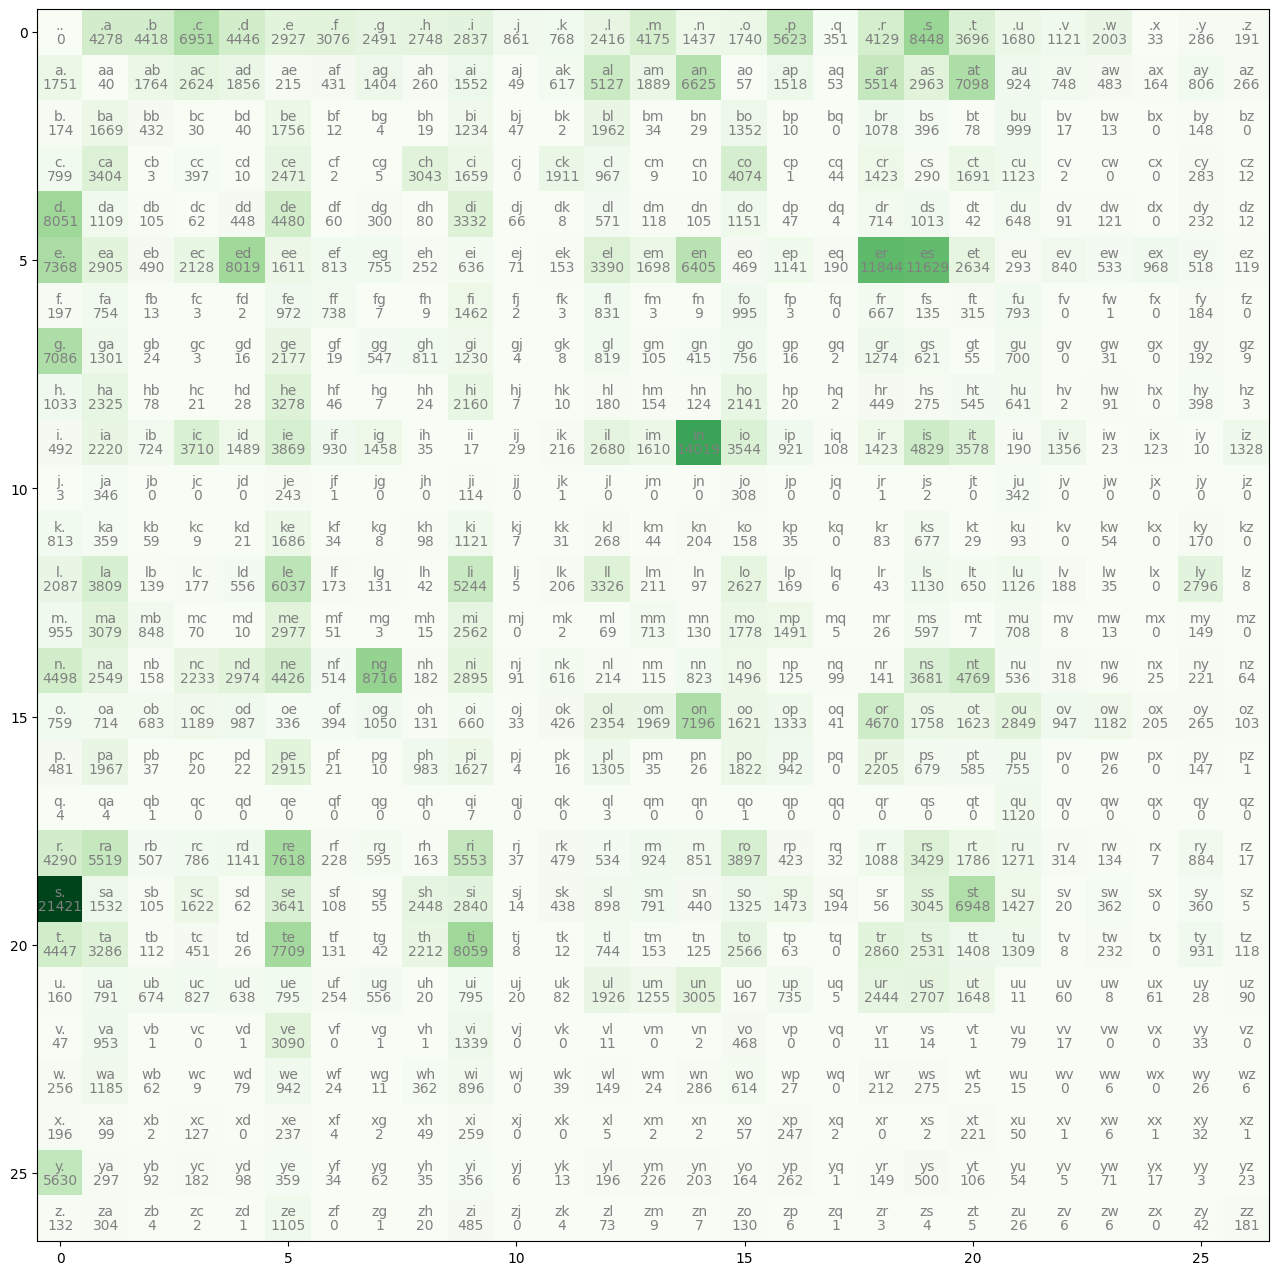

In [5]:
makemore.plot_bigram_frequencies(counts)

# sample

In [6]:
# added count of 1 for smoothing out unobserved bigrams
count_dists = (counts+1).float()
count_dists /= count_dists.sum(1, keepdim=True)

In [7]:
seed = 2**31 - 1
print(f" --- using seed {seed} --- ")
g = torch.Generator().manual_seed(seed)

def get_sample(P):
  samples = torch.multinomial(P, num_samples=1, replacement=True, generator=g)
  return samples[0].item()

P = count_dists[0]
curr_idx = get_sample(P)
output = CHARS[curr_idx]

for i in range(200):
  P = count_dists[curr_idx]
  curr_idx = get_sample(P)
  output += ' ' if curr_idx == 0 else CHARS[curr_idx]
  
for word in output.split():
  print(f"{word}.")

 --- using seed 2147483647 --- 
probatt.
ppontissunes.
lpinogatala.
plitipuesin.
rahonified.
donchciormeseiomeevins.
g.
ct.
bbinus.
himiers.
sledionk.
ce.
facioning.
atrts.
ongessptaly.
cteskinblantyngutoredermmiesosthbls.
fts.
fiotutirs.
stind.
buelap.


In [13]:
test_words = ["szygy"]
anll = makemore.calculate_anll_loss(test_words, count_dists)
print(anll)

tensor(4.2221)
